# Community-Based Event Detection in Temporal Networks

The code below provides a set of routines that implement the proposed method for event detection, as described in

P. Moriano, J. Finke, and Y.-Y. Ahn, Community-Based Event Detection in Temporal Networks, 2018. 

The code below reproduces some of the results of the above mentioned paper, in particular, those for the Enron dataset. The code is released for illustrative purposes only. For questions, feel free to send an email to [pmoriano@indiana.edu](pmoriano@indiana.edu). To run it, you will need the data files *'employees.txt'* and *'execs.email.linesnum.ldctopic.txt'* available [here](http://www.cis.jhu.edu/~parky/Enron/).

Libraries required in the rest of the code

In [1]:
%matplotlib inline

from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.dates as dates
from matplotlib.dates import MO, TU, WE, TH, FR, SA, SU
import igraph as ig
import time
from datetime import datetime, timedelta
import itertools
import os
import pickle
import scipy.stats as stats
import operator

## Load employee and email data

Load the two datasets neccesary to conduct the analysis.

In [2]:
print os.getcwd()
os.chdir("/l/nx/user/pmoriano/event_detection/network_data.NOBACKUP")
print os.getcwd()

name_list = []

with open('employees.txt') as f:
    for line in f:
        inner_list = [elem.strip() for elem in line.split()]
        name_list.append(inner_list) 
        
name_dic = {employee_index:name_list[employee_index][0] for employee_index in range(len(name_list))}
lookup = lambda name: name_dic[name]


df = pd.read_csv('execs.email.linesnum.ldctopic.txt', sep=' ', skip_blank_lines=True)
df.columns = ['time', 'sender', 'receiver', 'topic']
df['index'] = df.index.tolist()
df = df.set_index(pd.DatetimeIndex(pd.to_datetime(df['time'], unit='s')))
df['sender_name'] = df['sender'].map(lookup)
df['receiver_name'] = df['receiver'].map(lookup)
df = df[['index', 'time', 'sender', 'receiver', 'sender_name', 'receiver_name', 'topic']]

print df.head(n=10)
print df.tail(n=10)

/home/nx/user/pmoriano/event_detection/code
/home/nx/user/pmoriano/event_detection/network_data.NOBACKUP
                     index       time  sender  receiver        sender_name  \
time                                                                         
1979-12-31 21:00:00      1  315522000      24       153       daren.farmer   
1979-12-31 21:00:00      2  315522000      24       153       daren.farmer   
1979-12-31 21:00:00      3  315522000      29        29  debra.perlingiere   
1979-12-31 21:00:00      4  315522000      29        29  debra.perlingiere   
1979-12-31 21:00:00      5  315522000      29        29  debra.perlingiere   
1979-12-31 21:00:00      6  315522000      29        29  debra.perlingiere   
1979-12-31 21:00:00      7  315522000      38        38    elizabeth.sager   
1979-12-31 21:00:00      8  315522000      51        66       greg.whalley   
1979-12-31 21:00:00      9  315522000      51        66       greg.whalley   
1979-12-31 21:00:00     10  315522000

## Generate dates of events

This is the list of important Enron events.

In [3]:
# Look at this: http://www.nature.com/article-assets/npg/srep/2016/161222/srep39713/extref/srep39713-s1.pdf
# More extensive source of events: http://www.agsm.edu.au/bobm/teaching/BE/Enron/timeline.html


# May 17, 2001 -- "Secret" meeting at Peninsula Hotel in LA -- Schwarzenegger, Lay, Milken.
# July 12, 2001 -- Quarterly Conference Call. Skilling still bullish. 
# August 3, 2001 -- Skilling makes a bullish speech on EES. That afternoon, he lays off 300 employees. 
# Oct. 16, 2001 -- Enron reports a $618 million third-quarter loss and declares a $1.01 billion non-recurring charge against its balance sheet, partly related to "structured finance" operations run by chief financial officer Andrew Fastow. In the analyst conference call that day, Lay also announces a $1.2 billion cut in shareholder equity. 
# Dec. 2, 2001 -- Enron files for Chapter 11 bankruptcy protection, at the time the largest bankruptcy in US history. 
# Feb. 14, 2002 -- Sherron Watkins, the Enron whistleblower, testifies before a Congressional panel against Skilling and Lay.
# April 9, 2002 -- David Duncan, Arthur Andersen's former top Enron auditor, pleads guilty to obstruction. 


dates_of_key_events = ["2001-05-17", "2001-07-12", "2001-08-03", "2001-10-16", "2001-12-02", "2002-02-14", "2002-04-09"]
dates_list = [datetime.strptime(date, '%Y-%m-%d') for date in dates_of_key_events]

## Original weekly time series

This is the original times series with a focus on dates between *'1999-01-01'* and *'2002-04-30'*.

In [4]:
temp = df['time'].resample('W').count()
temp = temp['1999-01-01':'2002-04-30']
temp.head()

time
1999-01-03     6
1999-01-10    24
1999-01-17    42
1999-01-24    16
1999-01-31    18
Freq: W-SUN, Name: time, dtype: int64

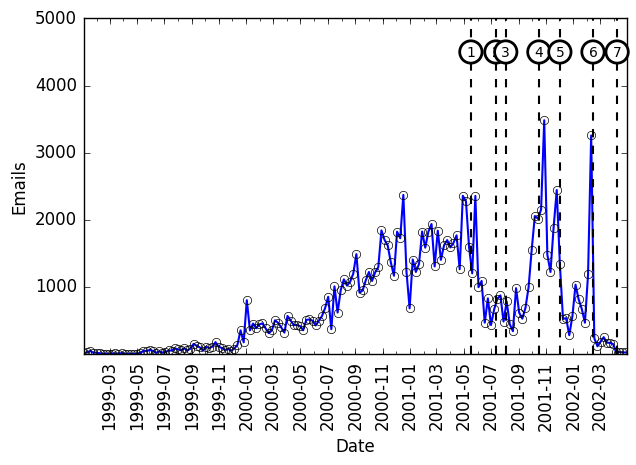

In [5]:
size = 7
fig = plt.figure(figsize=(size, size/1.618))

ax1 = fig.add_subplot(111)

x = temp.index.to_pydatetime()
y = temp.values

ax1.plot(x, y, color='blue', linewidth=1.5, linestyle='-', marker = 'o', mfc = 'None')
#ax1.set_yscale("log") 

# Assign labels
ax1.set_xlabel('Date', labelpad=5)      
ax1.set_ylabel('Emails', labelpad=5)  

# Assign font size
for label in ([ax1.xaxis.label, ax1.yaxis.label]):
    label.set_fontsize(12)

ax1.xaxis.set_major_locator(dates.MonthLocator(bymonth=range(1,13), bymonthday=1, interval=2))
ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))
ax1.xaxis.set_minor_locator(dates.DayLocator(bymonthday=1, interval=1, tz=None))
   
# x axis
for tl in ax1.get_xticklabels():
    tl.set_fontsize(12)

# y axis
for tl in ax1.get_yticklabels():
    tl.set_fontsize(12)
    
# Change ticks space
ax1.tick_params(axis='both', which='major', pad=5)
    
# Rotate tick labels
plt.setp(plt.xticks()[1], rotation=90)

# Setup the limit
ax1.set_ylim([1*10**0, 0.5*10**4])
ax1.set_xlim([datetime(1999, 1, 3, 0, 0), datetime(2002, 4, 30, 0, 0)])

# Add vertical lines
for date in dates_list:
    ax1.axvline(date, color='black', linewidth=1.5, linestyle='--')

# Annotations
bbox_props = dict(boxstyle="circle,pad=0.3", fc="white", ec="black", lw=2)
ax1.text(dates_list[0], 4500, "1", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax1.text(dates_list[1], 4500, "2", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax1.text(dates_list[2], 4500, "3", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax1.text(dates_list[3], 4500, "4", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax1.text(dates_list[4], 4500, "5", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax1.text(dates_list[5], 4500, "6", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax1.text(dates_list[6], 4500, "7", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)

plt.show()

## Weekly time series observation period

This is the period after the cumulative graph segment has been formed. See detail on the paper about the selection of this value.

In [6]:
set_point_string = '2000-10-01'

temp = df["time"].resample("W").count()
temp = temp[set_point_string:"2002-04-30"] # "1999-01-01"
print temp.head()

time
2000-10-01    1220
2000-10-08    1086
2000-10-15    1215
2000-10-22    1291
2000-10-29    1840
Freq: W-SUN, Name: time, dtype: int64


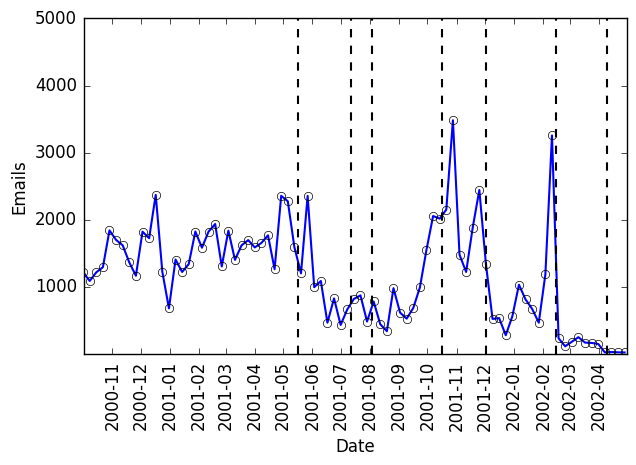

In [7]:
size = 7
fig = plt.figure(figsize=(size, size/1.618), dpi=200)

ax = fig.add_subplot(111)

x = temp.index.to_pydatetime()
y = temp.values

ax.plot(x, y, color='blue', linewidth=1.5, linestyle='-', marker = 'o', mfc = 'None')
#ax.set_yscale("log") 

# Assign labels
ax.set_xlabel('Date', labelpad=5)      
ax.set_ylabel('Emails', labelpad=5)  

# Assign font size
for label in ([ax.xaxis.label, ax.yaxis.label]):
    label.set_fontsize(12)

ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=range(1,13), bymonthday=1, interval=1)) 
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))
   
# x axis
for tl in ax.get_xticklabels():
    tl.set_fontsize(12)

# y axis
for tl in ax.get_yticklabels():
    tl.set_fontsize(12)
    
# Change ticks space
ax.tick_params(axis='both', which='major', pad=5)
    
# Rotate tick labels
plt.setp(plt.xticks()[1], rotation=90)

# Setup the limit
ax.set_ylim([1*10**0, 0.5*10**4])
ax.set_xlim([datetime(2000, 10, 2, 0, 0), datetime(2002, 4, 30, 0, 0)])

# Add vertical lines
for date in dates_list:
    ax.axvline(date, color='black', linewidth=1.5, linestyle='--')

plt.show()

## Time series with standard deviation

This corresponds to the time series considering the meana dn standard deviation calculated for the observation period.

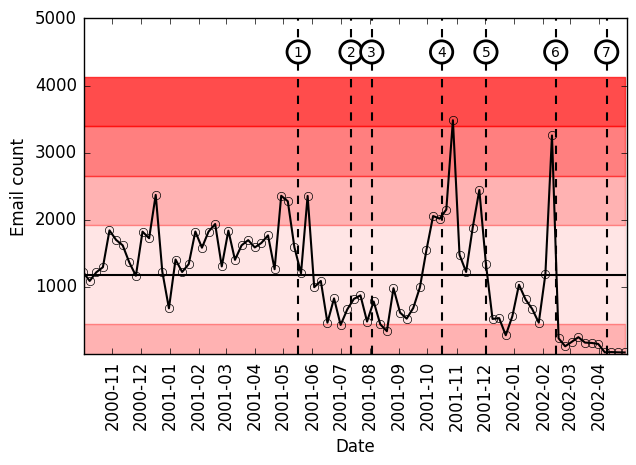

In [8]:
size = 7
fig = plt.figure(figsize=(size, size/1.618), dpi=200)

ax = fig.add_subplot(111)

x = temp.index.to_pydatetime()
y = temp.values
raw_count_emails = y

mean = np.repeat(np.nanmean(y), len(y)) # Y1[0:window_offset]
sd = np.repeat(np.nanstd(y), len(y))

ax.plot(x, y, color='black', linewidth=1.5, linestyle='-', marker='o', mfc='None')
ax.plot(x, mean, color="black", linewidth=1.5)


# Band scale
sigma = 1.0
ax.fill_between(x, mean - sigma*sd, mean + sigma*sd, color="red", alpha=0.10)

ax.fill_between(x, mean + sigma*sd, mean + 2*sigma*sd, color="red", alpha=0.30)
ax.fill_between(x, mean - sigma*sd, mean - 2*sigma*sd, color="red", alpha=0.30)

ax.fill_between(x, mean + 2*sigma*sd, mean + 3*sigma*sd, color="red", alpha=0.50)
ax.fill_between(x, mean - 2*sigma*sd, mean - 3*sigma*sd, color="red", alpha=0.50)

ax.fill_between(x, mean + 3*sigma*sd, mean + 4*sigma*sd, color="red", alpha=0.70)
ax.fill_between(x, mean - 3*sigma*sd, mean - 4*sigma*sd, color="red", alpha=0.70)

#ax.set_yscale("log") 

# Assign labels
ax.set_xlabel('Date', labelpad=5)      
ax.set_ylabel('Email count', labelpad=5)  

# Assign font size
for label in ([ax.xaxis.label, ax.yaxis.label]):
    label.set_fontsize(12)

ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=range(1,13), bymonthday=1, interval=1)) 
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))

# x axis
for tl in ax.get_xticklabels():
    tl.set_fontsize(12)

# y axis
for tl in ax.get_yticklabels():
    tl.set_fontsize(12)

# Change ticks space
ax.tick_params(axis='both', which='major', pad=5)

# Rotate tick labels
plt.setp(plt.xticks()[1], rotation=90)

# Setup the limit
ax.set_ylim([1*10**0, 0.5*10**4])
ax.set_xlim([datetime(2000, 10, 2, 0, 0), datetime(2002, 4, 30, 0, 0)])

# Add vertical lines
for date in dates_list:
    ax.axvline(date, color='black', linewidth=1.5, linestyle='--')

# Annotations

bbox_props = dict(boxstyle="circle,pad=0.3", fc="white", ec="black", lw=2)
ax.text(dates_list[0], 4500, "1", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[1], 4500, "2", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[2], 4500, "3", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[3], 4500, "4", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[4], 4500, "5", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[5], 4500, "6", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[6], 4500, "7", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)

plt.show()

## Time series with standrad deviation using rolling mean

This corresponds to the time series using the mean and standard deviation using the rolling mean method. 

In [38]:
set_point = "2000-10-01" 

temp = df['time'].resample('W').count()
temp = temp[set_point:'2002-04-30']

# Equivalent to a year of observations
window_length = 52
mean = temp.rolling(window=window_length, center=True, min_periods=1).mean()
sd = temp.rolling(window=window_length, center=True, min_periods=1).std()

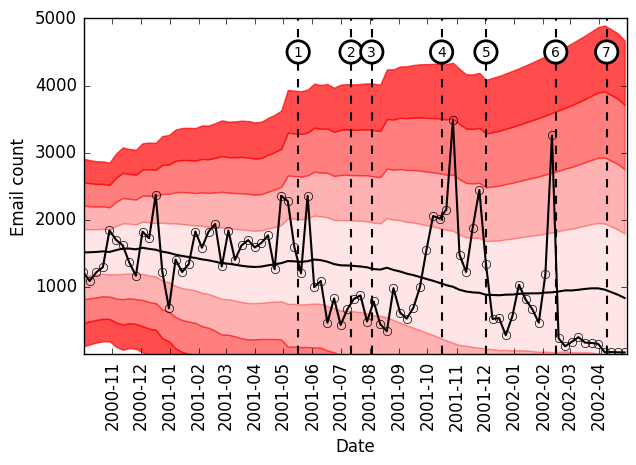

In [39]:
size = 7
fig = plt.figure(figsize=(size, size/1.618), dpi=200)

ax = fig.add_subplot(111)

x = temp.index.to_pydatetime()
y = temp.values
raw_count_emails = y

array_means = mean.values
array_stds = sd.values

ax.plot(x, y, color='black', linewidth=1.5, linestyle='-', marker='o', mfc='None')
ax.plot(x, array_means, color="black", linewidth=1.5)

# Band scale
sigma = 1.0
ax.fill_between(x, array_means - sigma*array_stds, array_means + sigma*array_stds, color="red", alpha=0.10)

ax.fill_between(x, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="red", alpha=0.30)
ax.fill_between(x, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="red", alpha=0.30)

ax.fill_between(x, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="red", alpha=0.50)
ax.fill_between(x, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="red", alpha=0.50)

ax.fill_between(x, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="red", alpha=0.70)
ax.fill_between(x, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="red", alpha=0.70)


#ax.set_yscale("log") 

# Assign labels
ax.set_xlabel('Date', labelpad=5)      
ax.set_ylabel('Email count', labelpad=5)  

# Assign font size
for label in ([ax.xaxis.label, ax.yaxis.label]):
    label.set_fontsize(12)

ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=range(1,13), bymonthday=1, interval=1)) 
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))

# x axis
for tl in ax.get_xticklabels():
    tl.set_fontsize(12)

# y axis
for tl in ax.get_yticklabels():
    tl.set_fontsize(12)

# Change ticks space
ax.tick_params(axis='both', which='major', pad=5)

# Rotate tick labels
plt.setp(plt.xticks()[1], rotation=90)

# Setup the limit
ax.set_ylim([1*10**0, 0.5*10**4])
ax.set_xlim([datetime(2000, 10, 2, 0, 0), datetime(2002, 4, 30, 0, 0)])

# Add vertical lines
for date in dates_list:
    ax.axvline(date, color='black', linewidth=1.5, linestyle='--')


# Annotations

bbox_props = dict(boxstyle="circle,pad=0.3", fc="white", ec="black", lw=2)
ax.text(dates_list[0], 4500, "1", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[1], 4500, "2", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[2], 4500, "3", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[3], 4500, "4", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[4], 4500, "5", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[5], 4500, "6", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)
ax.text(dates_list[6], 4500, "7", ha="center", va="center", rotation=0, size=10, bbox=bbox_props)

plt.show()

## Proposed measure

Set of routines to compute the proposed measure in the method. Look at the specific details of each routine for more details. 

In [11]:
def create_graph(data_frame):
    """
    Create a weighted an directed network from the data frame
    @param data_frame: the data frame to build the network
    """

    sender_list = list(data_frame['sender_name'].unique())
    receiver_list = list(data_frame['receiver_name'].unique())
    sender_receiver_list = sender_list + receiver_list
    # Get a list of rows [sender, receiver, topic]
    rows = data_frame[["sender_name", "receiver_name", "topic"]]
    rows = rows.values
    # Get a list of edges
    list_of_edges = [(row[0], row[1]) for row in rows]
    # Get a list of topics
    list_of_topics = [row[2] for row in rows]


    # Create the graph object
    G = ig.Graph(directed=True)
    # Add nodes
    G.add_vertices(sender_receiver_list)
    # Add edges
    G.add_edges(list_of_edges)
    # Set the weight of every edge to 1
    G.es['weight'] = 1
    # Set the topic of every edge
    G.es['topic'] = list_of_topics
    # Assign labels for visualization
    G.vs['label'] = G.vs['name']

    # print G.summary()
    
    return G


def simplify_graph(graph):
    
    """
    Simplify the graph (main component, reciprocal connections, undirected unweighted, simplify)
    @param graph: Graph to be simplified
    @return: g4: Simplified graph (list)
    """
    
    # Lambda function to get the topics of the edges
    pass_topic = lambda topic_list: topic_list
    
    # Get the main weakest component
    components = graph.components('weak')
    g = components.giant()
    
    # Get the edge list of the weakest component
    edge_list = g.get_edgelist()
    
    # Get a boolean vector of reciprocal links
    logic = g.is_mutual()
    
    # Get the indices of reciprocal links
    reciprocal_ids = [index for index in range(len(logic)) if logic[index] == True] 
    
    # Get a subgraph with only reciprocal links
    g1 = g.subgraph_edges(reciprocal_ids, delete_vertices=False)
  
    # Get an undirected version but combining the edges
    g2 = g1.copy()
    
    # Turn into undirected multiple directed edges
    # g2.to_undirected(mode='collapse', combine_edges={'weight':'sum'})
    g2.to_undirected(mode='collapse', combine_edges={'weight':'sum', 'topic':pass_topic})

    # Remove self-loops and multiple edges but still combine edges
    g3 = g2.copy()
    
    # Remove self-loops and multiple undirected edges
    g3.simplify(multiple=True, loops=True, combine_edges={'weight':'sum', 'topic':pass_topic})
    
    # Remove nodes with degree 0
    g4 = g3.copy()
    to_delete_ids = [v.index for v in g3.vs if g3.degree(v.index) == 0]
    # print "deleted: ", len(to_delete_ids)
    
    # Deleted for the experiment
    g4.delete_vertices(to_delete_ids)
    # print g4.vcount(), g4.ecount()
    
    return g4


def partition_df(start_date, end_date, window_length, offset):

    """
    Generate the the start and end dates stream to partition the data frames
    @param start_date: Beginning date
    @param end_date: Final date
    @param window_length: Number of days of the window
    @param offset: Offset of the window
    @return: partition_list: List with the prtition of dates (list)
    """
    
    # List of tuples to store the partition
    partition_list = []
    
    # Get the range of dates, beginning and end dates
    range_of_dates = pd.date_range(start=start_date, end=end_date, freq='D')
    start_date_datetime = datetime.strptime(start_date, '%Y-%m-%d')
    end_date_datetime = range_of_dates[-1]
    
    # Check if the start date it is not Monday
    # Weekdays 0: Monday, 1: Tuesday, 2: Wednesday, 3: Thursday, 4: Friday, 5: Saturday, 6: Sunday
    beginning_week_day = start_date_datetime.weekday()
    if beginning_week_day > 0:
        partition_list.append((start_date_datetime.strftime('%Y-%m-%d %H:%M:%S'), range_of_dates[6 - beginning_week_day + 1].strftime('%Y-%m-%d %H:%M:%S')))
        start_date_datetime = range_of_dates[6 - beginning_week_day] + timedelta(days=1)
    
    # Check if reach the last date
    while start_date_datetime + timedelta(days=window_length) < end_date_datetime:
        partition_list.append((start_date_datetime.strftime('%Y-%m-%d %H:%M:%S'), (start_date_datetime + timedelta(days=window_length)).strftime('%Y-%m-%d %H:%M:%S'))) 
        start_date_datetime = start_date_datetime + timedelta(days=offset)
    
    # Add the last set of dates
    if start_date_datetime != end_date_datetime:
        partition_list.append((start_date_datetime.strftime('%Y-%m-%d %H:%M:%S'), end_date_datetime.strftime('%Y-%m-%d %H:%M:%S')))
    
    return partition_list


def get_vertexlist_ids_name(G):
    """
    Calculate a list with vertex names
    @param G: graph to analyze (igraph object)
    @return: id_list (list)
    """

    id_list = []

    for v in G.vs:
        id_list.append(v["name"])

    return id_list


def communities_partition(membership_list, name_list):
    """
    Create a dictionary of memberships {name: community_id}
    @param membership list: membership of every node in order (list)
    @param name_list: name of the nodes (list)
    @return: id_list (list)
    """

    # Dictionary to return the partition
    partition_dic = {}

    # Assign the community id to the node name
    for member_index in xrange(0, len(membership_list)):
        partition_dic[name_list[member_index]] = membership_list[member_index]


    return partition_dic


def compute_inter_intra_enron(df, date_range_list, partition_dic):
    """
    Create a dictionary of memberships {name: community_id}
    @param membership list: membership of every node in order (list)
    @param name_list: name of the nodes (list)
    @return: id_list (list)
    """

    # Dics to store the result
    dic_inter = {k:{} for k in date_range_list}
    dic_intra = {k:{} for k in date_range_list}

    #count = 0

    for week in date_range_list:

        #print week[0], type(week[0]), week[1], type(week[1])
        df_filtered = df[week[0]:week[1]]

        #print df_filtered.head()

        df_filtered = df_filtered[["sender_name", "receiver_name", "topic"]]
        rows = df_filtered.values
        list_of_edges = [(row[0], row[1]) for row in rows]

        #print list_of_edges[0:10]

        for edge in list_of_edges:

            row0_existed = edge[0] in partition_dic
            row1_existed = edge[1] in partition_dic

            if row0_existed and row1_existed:
                #print "entre"

                row0_partition = partition_dic[edge[0]]
                row1_partition = partition_dic[edge[1]]

                # If nodes are in the same community (intra)
                if row0_partition == row1_partition:
                    # Check if that hour already exist
                    if row0_partition in dic_intra[week]:
                        dic_intra[week][row0_partition] = dic_intra[week][row0_partition] + 1
                    # If not create
                    else:
                        dic_intra[week][row0_partition] = 1

                # Nodes are in different communities (inter)
                else:
                    if row0_partition in dic_inter[week]:
                        dic_inter[week][row0_partition] = dic_inter[week][row0_partition] + 1
                    else:
                        dic_inter[week][row0_partition] = 1

                    if row1_partition in dic_inter[week]:
                        dic_inter[week][row1_partition] = dic_inter[week][row1_partition] + 1
                    else:
                        dic_inter[week][row1_partition] = 1


    return dic_inter, dic_intra


## Running the proposed method

Generate the cumulative graph segment G0.

In [12]:
set_point_string = '2000-10-01'

G = create_graph(df["1999-01-01":set_point_string]) 
print G.vcount(), G.ecount()
g = simplify_graph(G)
print g.vcount(), g.ecount()

222 28686
81 199


## Compute community partition

Use infomap method to compute the community partition of the cumulative graph segment. 

In [13]:
# Infomap algorithm
communities = g.community_infomap(edge_weights="weight", vertex_weights=None, trials=10)

# Get the membership of every node
membership = communities.membership

# Get the partition dic
partition_dic = communities_partition(membership, get_vertexlist_ids_name(g))


print max(membership) + 1
print {k: partition_dic[k] for k in partition_dic.keys()[:10]}

9
{'michelle.cash': 0, 'dan.hyvl': 0, 'don.baughman': 8, 'darron.giron': 2, 'john.hodge': 7, 'lindy.donoho': 3, 'john.arnold': 1, 'vince.kaminski': 1, 'sally.beck': 1, 'chris.germany': 7}


## Inter-intra count

Compute the number of inter and intra links

In [14]:
date_range_list = partition_df(set_point_string, "2002-04-30", 7, 7)
print date_range_list[0:10]

dic_inter, dic_intra = compute_inter_intra_enron(df, date_range_list, partition_dic)
print {k: dic_intra[k] for k in dic_intra.keys()[:2]}


X = []
Y_inter = [] 
Y_intra = []

for week in date_range_list:
    
    X.append(datetime.strptime(week[1], "%Y-%m-%d %H:%M:%S"))
    Y_inter.append(sum(dic_inter[week].values()))
    Y_intra.append(sum(dic_intra[week].values()))  

[('2000-10-01 00:00:00', '2000-10-02 00:00:00'), ('2000-10-02 00:00:00', '2000-10-09 00:00:00'), ('2000-10-09 00:00:00', '2000-10-16 00:00:00'), ('2000-10-16 00:00:00', '2000-10-23 00:00:00'), ('2000-10-23 00:00:00', '2000-10-30 00:00:00'), ('2000-10-30 00:00:00', '2000-11-06 00:00:00'), ('2000-11-06 00:00:00', '2000-11-13 00:00:00'), ('2000-11-13 00:00:00', '2000-11-20 00:00:00'), ('2000-11-20 00:00:00', '2000-11-27 00:00:00'), ('2000-11-27 00:00:00', '2000-12-04 00:00:00')]
{('2000-10-30 00:00:00', '2000-11-06 00:00:00'): {0: 404, 1: 353, 2: 196, 3: 101, 5: 162, 6: 30, 7: 8, 8: 2}, ('2001-12-17 00:00:00', '2001-12-24 00:00:00'): {0: 14, 1: 24, 2: 3, 3: 27}}


## Compute ratio

Compute the proportion of those links given by Eq (1) and Eq (2).

In [15]:
ratio_inter_mention = []
ratio_intra_mention = []

for index in range(0, len(Y_inter)):
    
    if (Y_inter[index] + Y_intra[index]) == 0:
        ratio_inter_mention.append(np.nan)
        ratio_intra_mention.append(np.nan)
    else:
        ratio_inter_mention.append(Y_inter[index]/(Y_inter[index] + Y_intra[index]))
        ratio_intra_mention.append(Y_intra[index]/(Y_inter[index] + Y_intra[index]))

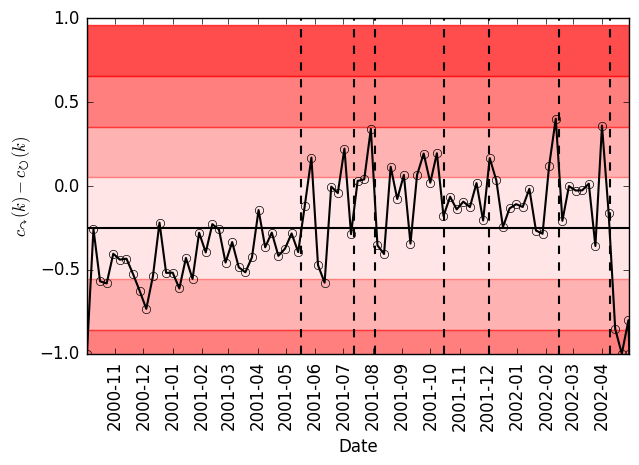

In [16]:
size = 7

fig = plt.figure(figsize=(size, size/1.618))
ax = plt.subplot()

Y1 = ratio_inter_mention
Y2 = ratio_intra_mention
Y1 = np.array(Y1)
Y2 = np.array(Y2)

mean = np.repeat(np.nanmean(Y1 - Y2), len(Y1)) # Y1[0:window_offset]
sd = np.repeat(np.nanstd(Y1 - Y2), len(Y1))

ax.plot(X, Y1-Y2, color='black', linewidth=1.5, linestyle='-', marker='o', mfc='None')
ax.plot(X, mean, color="black", linewidth=1.5)

# Band scale
sigma = 1.0
ax.fill_between(X, mean - sigma*sd, mean + sigma*sd, color="red", alpha=0.10)

ax.fill_between(X, mean + sigma*sd, mean + 2*sigma*sd, color="red", alpha=0.30)
ax.fill_between(X, mean - sigma*sd, mean - 2*sigma*sd, color="red", alpha=0.30)

ax.fill_between(X, mean + 2*sigma*sd, mean + 3*sigma*sd, color="red", alpha=0.50)
ax.fill_between(X, mean - 2*sigma*sd, mean - 3*sigma*sd, color="red", alpha=0.50)

ax.fill_between(X, mean + 3*sigma*sd, mean + 4*sigma*sd, color="red", alpha=0.70)
ax.fill_between(X, mean - 3*sigma*sd, mean - 4*sigma*sd, color="red", alpha=0.70)


# Assign labels
ax.set_xlabel('Date', labelpad=5)      
ax.set_ylabel('$c_{\curvearrowright}(k) - c_{\circlearrowright}(k)$', color='black', labelpad=5)  

# Assign font size
for label in ([ax.xaxis.label, ax.yaxis.label]):
    label.set_fontsize(12)

ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=range(1,13), bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))

# x axis
for tl in ax.get_xticklabels():
    tl.set_fontsize(12)

# y axis
for tl in ax.get_yticklabels():
    tl.set_fontsize(12)
    tl.set_color('black')

# Change ticks space
ax.tick_params(axis='both', which='major', pad=5)

# Rotate tick labels
plt.setp(plt.xticks()[1], rotation=90)

# Setup the limit
ax.set_ylim([-1.0, 1.0])
#ax.set_xlim([datetime(2000, 10, 2, 0, 0), datetime(2002, 4, 30, 0, 0)])

# Add vertical lines
for date in dates_list:
    ax.axvline(date, color='black', linewidth=1.5, linestyle='--')


plt.show()

## Rolling mean

Routine for computing the proposed measure for the entire period of study. 

In [17]:
def compute_inter_intra_community_ratio(g, partition_dic):
    """
    Compute the inter and intra community link ratio
    @param g: graph to analyze (igraph object)
    @param partition_dic: dictionary of communitites (dict)
    @return: inter minus intra community ratio(float)
    """
    
    # Get the list of edges by name
    edge_list = []
    
    for e in g.es: 
        edge = e.tuple
        edge_list.append((g.vs.select(edge[0])["name"][0], g.vs.select(edge[1])["name"][0]))
        
    dic_inter = {}
    dic_intra = {}
    
    for edge in edge_list:

        row0_existed = edge[0] in partition_dic
        row1_existed = edge[1] in partition_dic

        if row0_existed and row1_existed:   

            row0_partition = partition_dic[edge[0]]
            row1_partition = partition_dic[edge[1]]

            # If nodes are in the same community (intra)
            if row0_partition == row1_partition:
                # Check if that hour already exist
                if row0_partition in dic_intra:
                    dic_intra[row0_partition] = dic_intra[row0_partition] + 1
                # If not create
                else:
                    dic_intra[row0_partition] = 1

            # Nodes are in different communities (inter)
            else:
                if row0_partition in dic_inter:
                    dic_inter[row0_partition] = dic_inter[row0_partition] + 1
                else:
                    dic_inter[row0_partition] = 1

                if row1_partition in dic_inter:
                    dic_inter[row1_partition] = dic_inter[row1_partition] + 1
                else:
                    dic_inter[row1_partition] = 1
    
    intra_flow = np.sum(np.array(dic_intra.values())) 
    inter_flow = np.sum(np.array(dic_inter.values()))
    
    return (inter_flow / (intra_flow + inter_flow)) - (intra_flow / (intra_flow + inter_flow))



def compute_inter_intra_community_ratio_series(data_frame, start_date, end_date, window_length, offset, partition_dic):
    
    '''
    Compute the inter community ratio for every week
    @param data_frame: Data_frame eith the data
    @param start_date: Beginning date
    @param end_date: Final date
    @param window_length: Number of days of the window
    @param offset: Offset of the window
    @param times: Number of times to compute consensus
    @return data frame(df) data frame with the inter and intra community link ratio for the entire period of study
    '''
    
    # Get the right data
    data_frame = data_frame[['sender_name', 'receiver_name', 'topic']]
    
    # Partition the dates
    date_range_list = partition_df(start_date, end_date, window_length, offset)
    inter_intra_community_ratio_series = []

    start_time = time.time()

    for date_range in date_range_list:
        
        # print date_range
        
        # Select dates from a data frame
        temp_df = data_frame[date_range[0]:date_range[1]]
        # Create a graph from this data (weighted and directed)
        G = create_graph(temp_df)
        # Check if it is not an empty graph
        if G.vcount() > 0:
            # Apply simplification process (weighted and undirected)
            g = simplify_graph(G)
            # g = G.copy()
            # Check is the resultant graph is empty
            if g.vcount() > 0:
                # Get the consensus for a particular graph
                
                
                # # Infomap algorithm
                # communities = g.community_infomap(edge_weights="weight", vertex_weights=None, trials=10)

                # Get the membership of every node
                # membership = communities.membership

                # Get the partition dic
                # partition_dic = communities_partition_v2(membership, get_vertexlist_ids_name(g))
        
                inter_intra_community_ratio = compute_inter_intra_community_ratio(g, partition_dic)
                # Append the consensus result
                inter_intra_community_ratio_series.append(inter_intra_community_ratio)
            else:
                inter_intra_community_ratio_series.append(None)
        else:
            inter_intra_community_ratio_series.append(None)

    print('--- %s seconds ---' % (time.time() - start_time))   
    
    # Get the series of date time
    # date_time_series = [datetime.strptime(elem[1], '%Y-%m-%d %H:%M:%S') for elem in date_range_list]
    
    # Build a dictionary for the answer
    final_dic = {date_range_list[index][1]: [inter_intra_community_ratio_series[index]] for index in range(len(date_range_list))}
    final_dic = np.array([date_range_list, inter_intra_community_ratio_series])
    # print final_dic
    
    return pd.DataFrame(index=np.array(date_range_list)[:,1], data=inter_intra_community_ratio_series)


Compute the proposed measure for the entire period of study. 

In [32]:
temp = compute_inter_intra_community_ratio_series(df, '1999-01-01', '2002-04-30', 7, 7, partition_dic)
temp = temp[set_point_string:'2002-05-01']

--- 1.31892895699 seconds ---


/nfs/nfs5-insecure/home/insecure-ro/software/rhel6_x86_64/python2.7.10/lib/python2.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in double_scalars


Compute the rolling mean and standard deviation during the period of study.

In [33]:
window_length = 52
mean = temp.rolling(window=window_length, center=True, min_periods=1).mean()
sd = temp.rolling(window=window_length, center=True, min_periods=1).std()

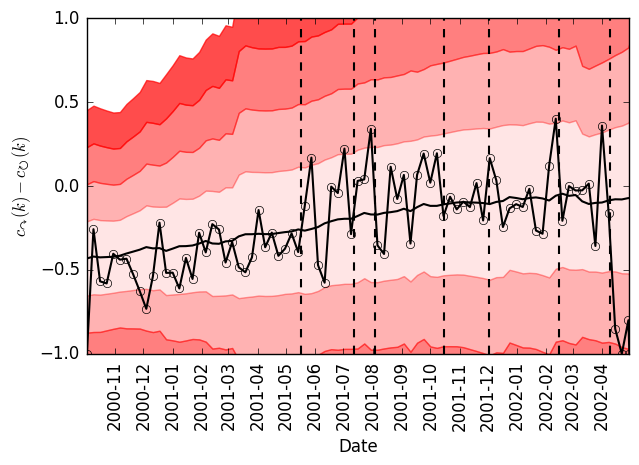

In [35]:
size = 7

fig = plt.figure(figsize=(size, size/1.618), dpi=200)
ax = plt.subplot()

Y1 = ratio_inter_mention
Y2 = ratio_intra_mention

Y1 = np.array(Y1)
Y2 = np.array(Y2)

array_means = mean.values.flatten()
array_stds = sd.values.flatten()


ax.plot(X, Y1-Y2, color='black', linewidth=1.5, linestyle='-', marker='o', mfc='None')
ax.plot(X, array_means, color="black", linewidth=1.5)

# Band scale
sigma = 1.0
ax.fill_between(X, array_means - sigma*array_stds, array_means + sigma*array_stds, color="red", alpha=0.10)

ax.fill_between(X, array_means + sigma*array_stds, array_means + 2*sigma*array_stds, color="red", alpha=0.30)
ax.fill_between(X, array_means - sigma*array_stds, array_means - 2*sigma*array_stds, color="red", alpha=0.30)

ax.fill_between(X, array_means + 2*sigma*array_stds, array_means + 3*sigma*array_stds, color="red", alpha=0.50)
ax.fill_between(X, array_means - 2*sigma*array_stds, array_means - 3*sigma*array_stds, color="red", alpha=0.50)

ax.fill_between(X, array_means + 3*sigma*array_stds, array_means + 4*sigma*array_stds, color="red", alpha=0.70)
ax.fill_between(X, array_means - 3*sigma*array_stds, array_means - 4*sigma*array_stds, color="red", alpha=0.70)


# Assign labels
ax.set_xlabel('Date', labelpad=5)      
ax.set_ylabel('$c_{\curvearrowright}(k) - c_{\circlearrowright}(k)$', color='black', labelpad=5)  

# Assign font size
for label in ([ax.xaxis.label, ax.yaxis.label]):
    label.set_fontsize(12)

ax.xaxis.set_major_locator(dates.MonthLocator(bymonth=range(1,13), bymonthday=1, interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m'))

# x axis
for tl in ax.get_xticklabels():
    tl.set_fontsize(12)

# y axis
for tl in ax.get_yticklabels():
    tl.set_fontsize(12)
    tl.set_color('black')

# Change ticks space
ax.tick_params(axis='both', which='major', pad=5)

# Rotate tick labels
plt.setp(plt.xticks()[1], rotation=90)

# Setup the limit
ax.set_ylim([-1.0, 1.0])
#ax.set_xlim([datetime(2000, 10, 2, 0, 0), datetime(2002, 4, 30, 0, 0)])

# Add vertical lines
for date in dates_list:
    ax.axvline(date, color='black', linewidth=1.5, linestyle='--')

plt.show()